# Gibbs sampling (MCMC)

Example of Gibbs sampling not conditioned on experimental data: https://syntopia.github.io/StatisticalLearning/SamplingMethodsFlashy.html

Sample Mean:  3.9800800643858567
Sample Precision:  2.0570533718179567
Sample Std dev:  0.6972318536701453


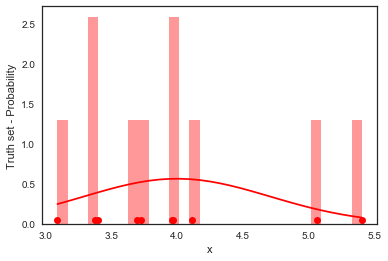

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import pymc3 as pm
import math
import matplotlib.mlab as mlab
from scipy.stats import gamma
from scipy.stats import gaussian_kde
import seaborn as sns
%matplotlib inline

fig = plt.figure()

# ------ generate our observated data from distribution

mu = 4 # mean of distribution
tau = 2 # precision = 1/standard deviation of distribution^2
n = 10 # number of samples drawn

x = np.random.normal(mu, 1/math.sqrt(tau),n)
sum_x = np.sum(x)

num_bins = 30
nh, bins, patches = plt.hist(x, num_bins, normed=1, facecolor='red', alpha=0.4)
y = mlab.normpdf(bins, mu, 1/math.sqrt(tau))
plt.plot(bins, y, 'r')
plt.xlabel('x')
plt.ylabel('Truth set - Probability')
plt.plot(x, np.zeros_like(x)+0.05, 'ro')

print ("Sample Mean: " , np.mean(x))
print ("Sample Precision: " , 1/(np.std(x)**2))
print ("Sample Std dev: " , np.std(x))
plt.show()

Let $X \sim \mathcal{N}(\mu,\,\tau)$, where $\mu,\,\tau$ are random vars. Let $X_i$ be a set of observed samples from $X$.

We want to know the joint distribution, given the data:
$P\left(\mu,\,\tau  \middle\vert X_i  \right)$ - from this we can get all information

We want to split this 2D distribution into two 1D PDF's, which we can sample using MCMC:
$P\left(\mu  \middle\vert X_i,\,\tau  \right)$ and $P\left(\tau \middle\vert X_i,\,\mu  \right)$

The mean:
$$P\left(\mu  \middle\vert X_i,\,\tau  \right) = \frac{P\left(X_i  \middle\vert \mu,\,\tau  \right) \times P(\mu)}{ P\left(X_i  \middle\vert \tau  \right)}$$


Let us define a prior for $\mu \sim \mathcal{N}(\mu_0,\,\tau_0)$ 

We need to calculate the product of the Normal likelihood with the Normal prior. Luckily this is a conjugate prior: https://en.wikipedia.org/wiki/Conjugate_prior, so the resulting distribution will be:

$$P\left(\mu  \middle\vert X_i,\,\tau  \right) \sim \mathcal{N}(\frac {\tau_{0}\mu_{0}+\tau \sum_{i=1}^{n}x_{i}}{\tau_{0}+n\tau },\,\tau _{0}+n\tau)$$


Now let us define a prior for the precision, $\tau$: $$\tau \sim \Gamma(\alpha,\beta)\!$$
$$P\left(\tau  \middle\vert X_i,\,\mu  \right)  \sim \Gamma(\alpha +{\frac{n}{2}},\,\beta +{\frac {\sum_{i=1}^{n}(x_{i}-\mu)^{2}}{2}})\!$$


posterior mean, stddev: 4.0392779672868455 0.27749095391836504
Mean:  3.9800800643858567
Precision:  2.0570533718179567


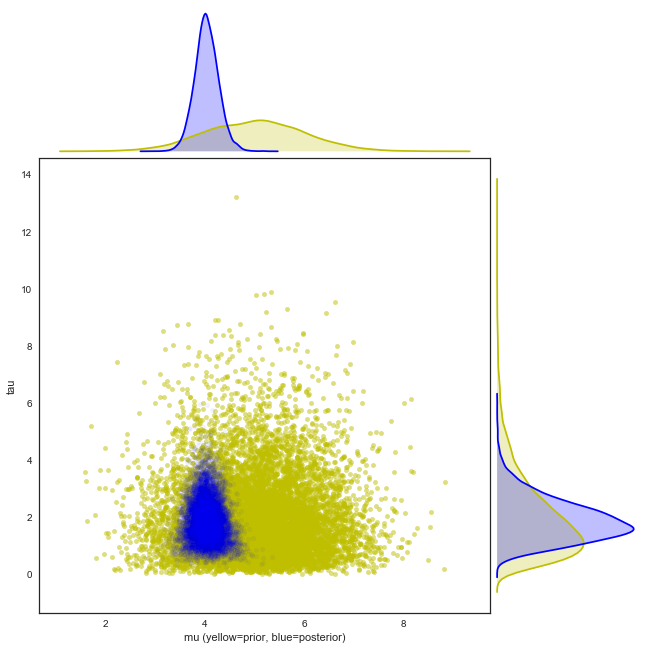

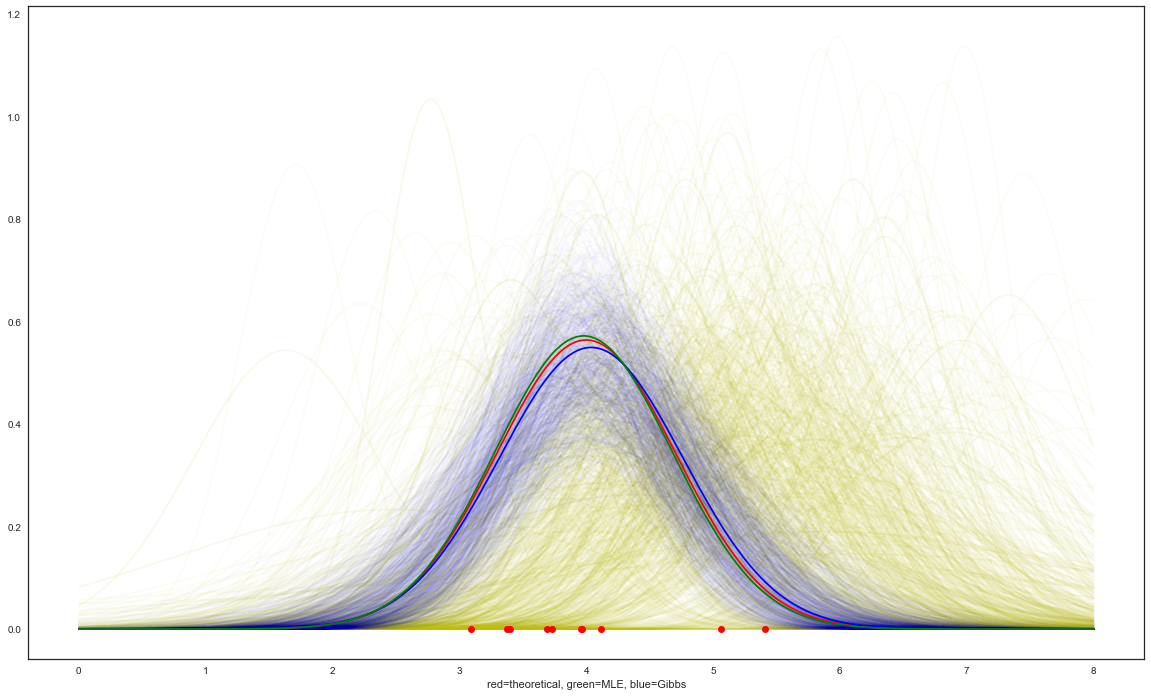

In [6]:
# ------- Setup priors -----------------------------------------------
mu_0 = 5
tau_0 = 1
alpha =2
beta = 1

# draw some numbers from priors (visualization only)
priorMus = np.random.normal(mu_0, 1/math.sqrt(tau_0),10000)
priorTaus = np.random.gamma(alpha, 1.0/beta,10000)

# ------ Actual Gibbs sampling -----------------------------------------
currentTau = 0
currentMu = 0
mus = []
taus = []

def getSample(mu_, tau_):
    mu_ = np.random.normal((mu_0*tau_0+tau_*sum_x)/(tau_0+n*tau_), 1/math.sqrt(tau_0+n*tau_))
    tau_ = np.random.gamma(alpha+n/2.0, 1.0/(beta+np.sum(((x-mu_) ** 2))/2.0))
    return (mu_, tau_)
  
# Burn-in    
for i in range(0, 1000):
    (currentMu, currentTau) = getSample(currentMu, currentTau)
  
# Sampling
for i in range(0, 10000):
    # Thinning
    for j in range(0,10):
        (currentMu, currentTau) = getSample(currentMu, currentTau)
    mus.append(currentMu)
    taus.append(currentTau)

# -------- Plots ------------------------------------------------------
sns.set(style="white")

g = sns.JointGrid(x=priorMus, y=priorTaus, size=9, ratio=3, space=0)
g = g.plot_joint(plt.scatter,color="y",  alpha=0.5, s=20)
g = g.plot_marginals(sns.kdeplot, color="y", shade=True)
g.x=np.array(mus)
g.y=np.array(taus)
g = g.plot_joint(plt.scatter,color="b",  alpha=0.05, s=20)
g = g.plot_marginals(sns.kdeplot, color="b", shade=True)
g.set_axis_labels("mu (yellow=prior, blue=posterior)","tau")


import random
num_bins = 30

fig = plt.figure(figsize=(20,12))

xa = np.linspace(0,8, 400)

for i in range(0, 1000):
    rnd = random.randint(0, len(priorMus)-1)
    y = mlab.normpdf(xa, priorMus[rnd], 1/math.sqrt(priorTaus[rnd]))
    plt.plot(xa, y, 'y', alpha=0.04)
    
for i in range(0, 1000):
    rnd = random.randint(0, len(mus)-1)
    y = mlab.normpdf(xa, mus[rnd], 1/math.sqrt(taus[rnd]))
    plt.plot(xa, y, 'b', alpha=0.01)

y = mlab.normpdf(xa, mu, 1/math.sqrt(tau))
plt.plot(xa, y, 'r')
y = mlab.normpdf(xa, np.mean(mus), 1/(np.mean(taus)**0.5))
plt.plot(xa, y, 'b')
y = mlab.normpdf(xa, np.mean(x), np.std(x))
plt.plot(xa, y, 'g')
print("posterior mean, stddev:", np.mean(mus), 1/(np.mean(taus)**2))
plt.plot(x, np.zeros_like(x)+0.00, 'ro')

print ("Mean: " , np.mean(x))
print ("Precision: " , 1/(np.std(x)**2))
plt.xlabel("red=theoretical, green=MLE, blue=Gibbs")    
plt.show()
